In [26]:
# run --include-dirty --name={datetime}-{task} configs/xprun/train.ron -t 
# task=bigfish,bossfight,cherry_pick,count,floor_is_lava,leaper,minefield,move_to_origin,multi_armed_bandit,multisnake_1snakes11len,multisnake_2snakes11len,not_hotdog,pick_matching_balls,plunder,rock_paper_scissors,starpilot,xor
# num_envs=32,128 lr=0.003,0.001,0.0003,0.0001
# dmodel=16,128 nlayer=1,2,4
# gamma=0.99 ent_coef=0.1 bs=512,4096
# --copies=1 --
# --config=configs/allsweep/{task}.ron total_timesteps=100000 track=true rollout.steps=16 rollout.processes=8
# rollout.num_envs={num_envs} optim.lr={lr} net.d_model={dmodel} net.n_layer={nlayer} ppo.gamma={gamma} ppo.ent_coef={ent_coef} optim.bs={bs}

import wandb
import csv
import json

def nested_lookup(key, nested_dict):
    for k in key:
        nested_dict = nested_dict[k]
    return nested_dict


def download_data(run_prefix: str, target_path: str, columns: dict):
    api = wandb.Api(timeout=100)
    runs = api.runs(
        "entity-neural-network/enn-ppo",
        filters={"config.name": {"$regex": f"{run_prefix}.*"}}
    )
    with open(target_path, "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(list(columns.keys()) + ["episodic_reward.mean", "episodic_reward.count", "reward.mean"])
        for run in runs:
            if run.name.startswith(run_prefix) and run:
                try:
                    summary = run.summary
                    if "episodic_reward.mean" not in summary:
                        print(f"{run.name} not finished")
                        continue
                    config = json.loads(run.json_config)
                    row = [
                        nested_lookup(path, config)
                        for path in columns.values()
                    ] + [
                        summary["episodic_reward.mean"],
                        summary["episodic_reward.count"],
                        summary["reward.mean"],
                    ]
                    writer.writerow(row)
                except Exception as e:
                    print(run.config)
                    print(run.summary)
                    raise e

download_data(
    #"220510-014942",
    #"220510-051349",
    "220510-144202",
    "data.csv",
    columns={
        "task": ["env", "value", "id"],
        "kwargs": ["env", "value", "kwargs"],
        "num_envs": ["rollout", "value", "num_envs"],
        "lr": ["optim", "value", "lr"],
        "dmodel": ["net", "value", "d_model"],
        "nlayer": ["net", "value", "n_layer"],
        "gamma": ["ppo", "value", "gamma"],
        "ent_coef": ["ppo", "value", "ent_coef"],
        "bs": ["optim", "value", "bs"],
    },
)

220510-144202-count-lr=0.001-ent_coef=0.1-dmodel=8-bs=512 not finished
220510-144202-cherry_pick-lr=0.001-ent_coef=0.1-dmodel=32-bs=2048 not finished
220510-144202-cherry_pick-lr=0.001-ent_coef=0.1-dmodel=128-bs=2048 not finished
220510-144202-cherry_pick-lr=0.001-ent_coef=0.1-dmodel=128-bs=512 not finished


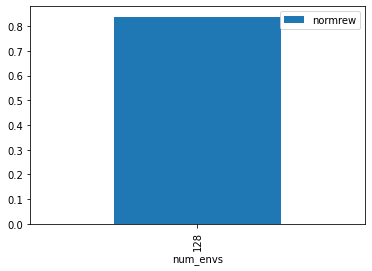

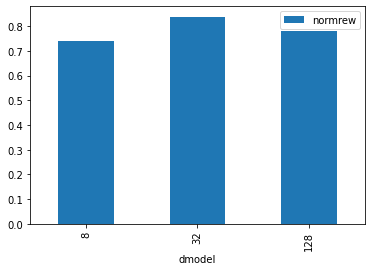

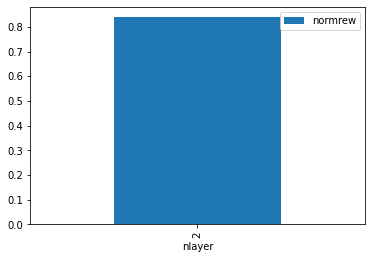

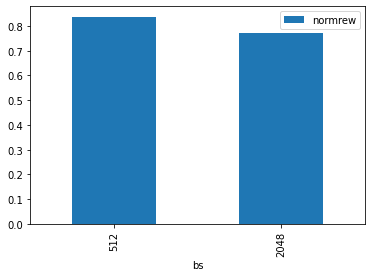

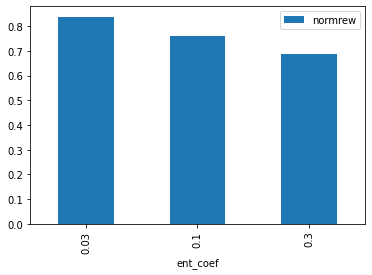

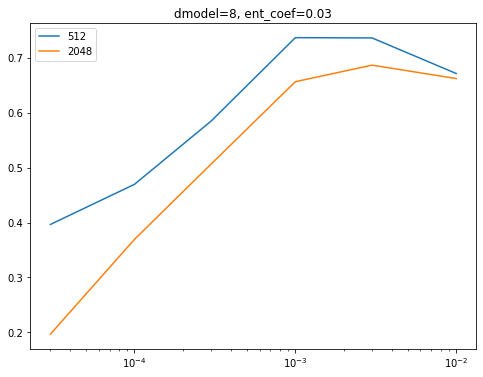

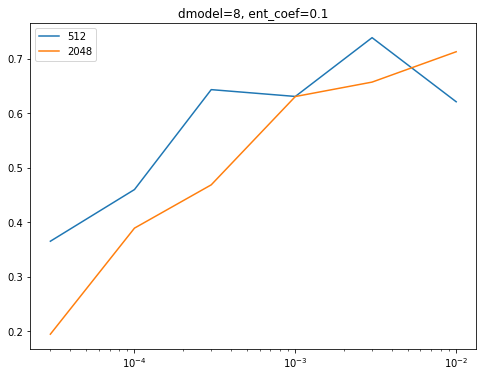

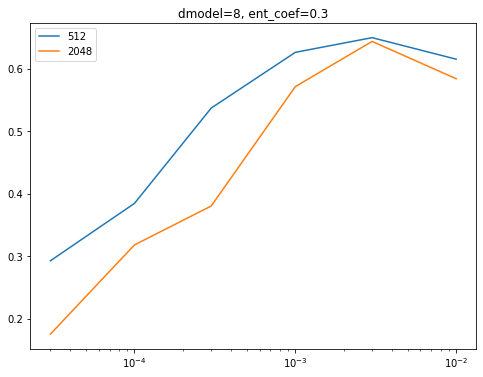

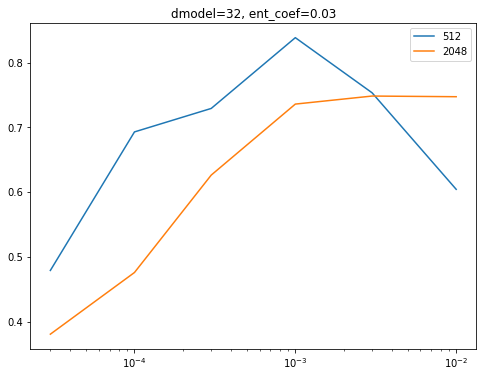

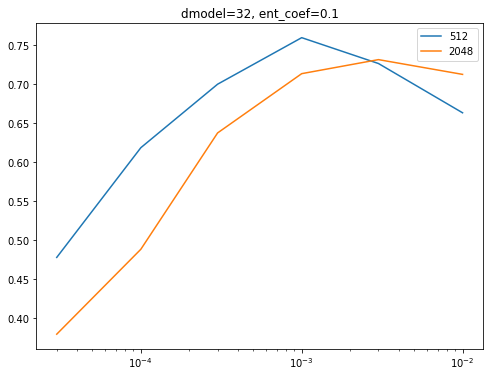

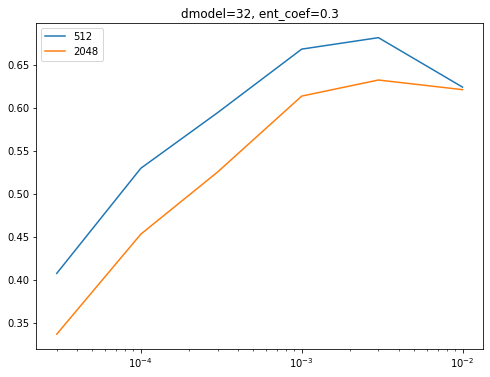

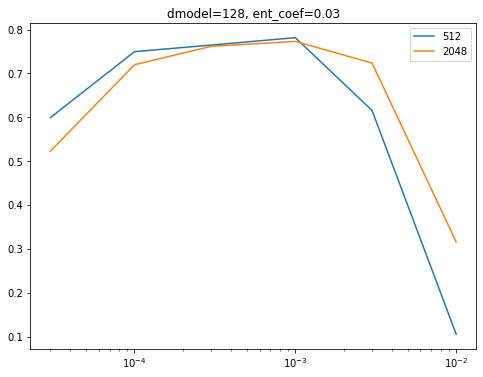

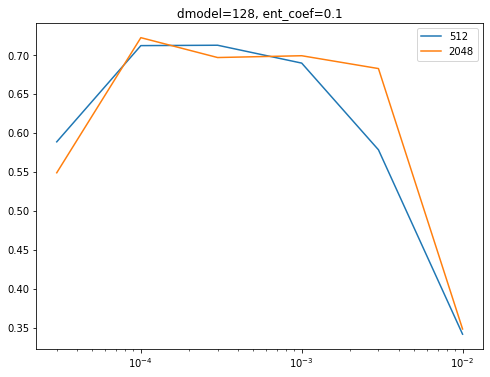

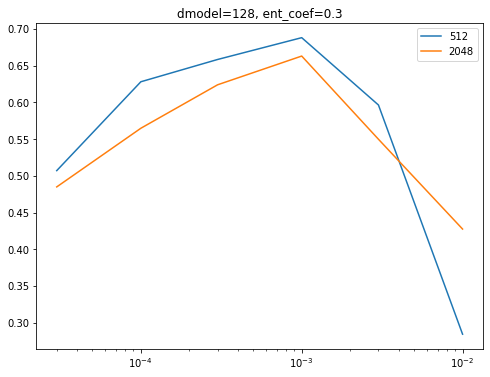

In [25]:
# Read data
import matplotlib.pyplot as plt
import pandas
df = pandas.read_csv("data.csv")
# Get count of each task
task_counts = df["task"].value_counts()
task_counts

# Add new column "normrew" initialized to 0
df["normrew"] = 0
# Add "normalized_reward" column which is the reward normalized to the min/max of the task
for task in task_counts.index:
    dft = df[df["task"] == task]
    df.loc[df["task"] == task, "normrew"] =  (dft["reward.mean"] - dft["reward.mean"].min()) / (dft["reward.mean"].max() - dft["reward.mean"].min())

# Filter out all tasks that don't start with "Procgen:"
# df = df[df["task"].str.startswith("Procgen:")]

# Aggregate over all tasks
df_agg = df.groupby(["num_envs", "lr", "dmodel", "nlayer", "gamma", "ent_coef", "bs"]).agg({"normrew": "mean"}).reset_index()

for param in ["num_envs", "dmodel", "nlayer", "bs", "ent_coef"]:
    df_envs = df_agg.groupby([param]).agg({"normrew": "max"}).reset_index()
    df_envs.plot(x=param, y="normrew", kind="bar")

for dmodel in [8, 32, 128]:
    for ent_coef in [0.03, 0.1, 0.3]:
        #for nlayer in [1, 2, 4]:
        #for bs in [512, 4096]:
        # Filter by dmodel, nlayer, num_envs
        _df = df_agg[df_agg["dmodel"] == dmodel]
        _df = _df[_df["ent_coef"] == ent_coef]
        #_df = _df[_df["nlayer"] == nlayer]
        # Plot reward.mean against learning rate for 32 and 128 environments
        fig, ax = plt.subplots(figsize=(8,6))
        #for num_envs in [32, 128]:
        for bs in [512, 2048]:
            __df = _df[_df["bs"] == bs]
            ax.plot(__df["lr"], __df["normrew"], label=f"{bs}")
        ax.set_xscale("log")
        ax.title.set_text(f"dmodel={dmodel}, ent_coef={ent_coef}")
        ax.legend()

In [19]:
df_agg.groupby(["ent_coef", "dmodel", "bs"]).agg({"normrew": "max"}).reset_index()

,ent_coef,dmodel,bs,normrew
0,0.03,8,512,0.737339
1,0.03,8,2048,0.687204
2,0.03,32,512,0.838461
3,0.03,32,2048,0.748306
4,0.03,128,512,0.781565
5,0.03,128,2048,0.773062
6,0.10,8,512,0.738569
7,0.10,8,2048,0.712751
8,0.10,32,512,0.759803
9,0.10,32,2048,0.731660


In [45]:
task_counts

MultiSnake           96
Procgen:StarPilot    48
Xor                  48
RockPaperScissors    48
Procgen:Plunder      48
PickMatchingBalls    48
NotHotdog            48
MultiArmedBandit     48
MoveToOrigin         48
Minefield            48
Procgen:Leaper       48
Count                48
FloorIsLava          48
Procgen:BossFight    48
CherryPick           48
Procgen:BigFish      48
Name: task, dtype: int64

In [23]:
df[(df["bs"] == 512) & (df["ent_coef"] == 0.03) & (df["dmodel"] == 32)].groupby("task").agg({"normrew": "max"}).reset_index()

,task,normrew
0,CherryPick,0.999928
1,Count,1.000000
2,FloorIsLava,1.000000
3,Minefield,0.980392
4,MoveToOrigin,0.701266
5,MultiArmedBandit,1.000000
6,MultiSnake,1.000000
7,NotHotdog,1.000000
8,PickMatchingBalls,0.684320
9,Procgen:BigFish,0.937500


In [50]:
df[df["task"] == "Procgen:BigFish"]

,task,num_envs,lr,dmodel,nlayer,gamma,ent_coef,bs,episodic_reward.mean,episodic_reward.count,reward.mean,normrew
16,Procgen:BigFish,128,0.0001,128,4,0.99,0.1,512,0.263158,19,0.002441,0.416667
33,Procgen:BigFish,128,0.0001,128,2,0.99,0.1,512,0.153846,26,0.001953,0.333333
50,Procgen:BigFish,128,0.0001,128,1,0.99,0.1,512,0.200000,25,0.000977,0.166667
66,Procgen:BigFish,128,0.0001,16,4,0.99,0.1,512,0.315789,19,0.001465,0.250000
84,Procgen:BigFish,128,0.0001,16,2,0.99,0.1,512,0.105263,19,0.002441,0.416667
101,Procgen:BigFish,128,0.0001,16,1,0.99,0.1,512,0.529412,17,0.002441,0.416667
118,Procgen:BigFish,128,0.0003,128,4,0.99,0.1,512,0.071429,14,0.002441,0.416667
134,Procgen:BigFish,128,0.0003,128,2,0.99,0.1,512,0.277778,18,0.001953,0.333333
152,Procgen:BigFish,128,0.0003,128,1,0.99,0.1,512,0.090909,11,0.000977,0.166667
169,Procgen:BigFish,128,0.0003,16,4,0.99,0.1,512,0.187500,16,0.000977,0.166667
